W zbiorze MNIST:

a). znaleźć NAJMNIEJ INFORMATYWNE cechy (piksele). Zobrazować je na rysunku, wielkością odpowiadającemu klasyfikowanym obrazkom.

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

n_features = x_train.shape[1] * x_train.shape[2]
n_samples = 2 * n_features
x_train, y_train = resample(x_train, y_train, n_samples=n_samples, replace=False, random_state=0)
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)

(1568, 784)


In [3]:
from sklearn import preprocessing
import statistics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train) # scaling data
print(x_train_scaled.shape)

(1568, 784)


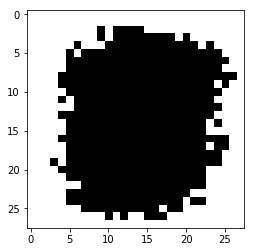

In [5]:
from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np

model_mnist = ExtraTreesClassifier()
model_mnist.fit(x_train_scaled, y_train)

feat_importances_mnist = pd.Series(model_mnist.feature_importances_)
worst_mnist_features = feat_importances_mnist.nsmallest(350).index.values

worst_image = np.zeros((784,))
for feature in worst_mnist_features:
    worst_image[feature] = 255
worst_image = worst_image.reshape((28,28))

plt.imshow(worst_image, cmap='gray')

b). Dokonać klasyfikacji k-nn na pełnym zbiorze i zbiorze bez m najmniej informatywnych cech.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_train_scaled, y_train, test_size=0.4, random_state=0)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.8280254777070064

In [8]:
x_train_sub = np.delete(x_train, worst_mnist_features, 1)
x_test_sub = np.delete(x_test, worst_mnist_features, 1)
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(x_train_sub, y_train)

y_pred = model.predict(x_test_sub)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.8296178343949044

c). Przetransformować zbiory przy pomocy PCA z N-D do N-D. Jak wyglądają (obrazki) wektory własne odpowiadające największym wartościom własnym. Sprawdzić, czy poprawił się wynik klasyfikacji. Dokonać wizualizacji 2-D przy pomocy PCA.

41.49663218293182


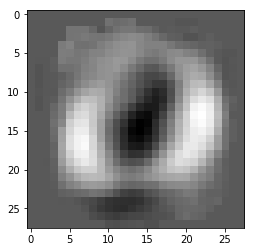

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=784)
pca.fit(x_train)
pca_x_train = pca.transform(x_train)
pca_x_test = pca.transform(x_test)

plt.imshow(pca.components_[0,:].reshape(28,28),cmap='gray')
print(pca.explained_variance_[0])

In [10]:
neigh_pca = KNeighborsClassifier(n_neighbors=5, algorithm='auto').fit(pca_x_train, y_train)
y_pred_pca = neigh_pca.predict(pca_x_test)

score = accuracy_score(y_true = y_test, y_pred = y_pred_pca)
score

0.8280254777070064

In [11]:
pca = PCA(2)

pca.fit(x_train)
principalComponents = pca.fit_transform(x_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(y_train, columns = ['labels'])], axis = 1)

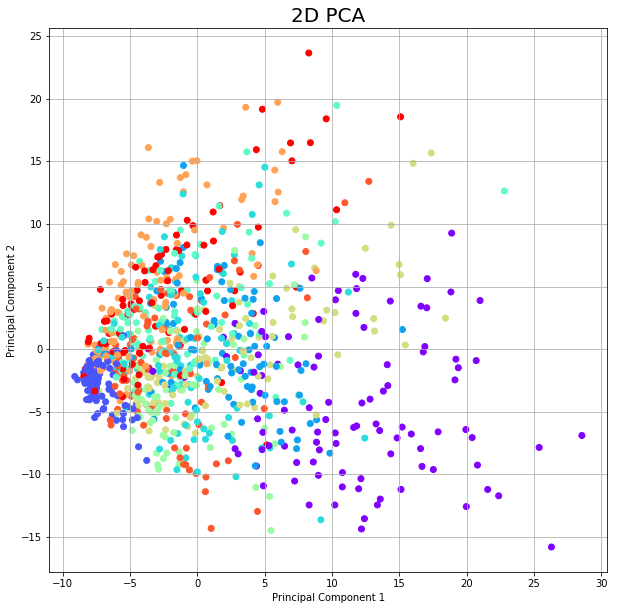

In [12]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2D PCA', fontsize = 20)
plt.scatter(principalComponents[:,0],principalComponents[:,1],c=y_train,cmap='rainbow')
ax.grid()

d. Usunąć m najmniej informatywnych cech PCA. Jak wygląda wynik klasyfikacji.

In [13]:
model_pca = ExtraTreesClassifier()
model_pca.fit(pca_x_train, y_train)

feat_importances_mnist = pd.Series(model_pca.feature_importances_)
worst_mnist_features = feat_importances_mnist.nsmallest(500).index.values

pca_x_train_sub = np.delete(pca_x_train, worst_mnist_features, 1)
pca_x_test_sub = np.delete(pca_x_test, worst_mnist_features, 1)
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(pca_x_train_sub, y_train)

y_pred = model.predict(pca_x_test_sub)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.8423566878980892

e). Wybrać m NAJLEPSZYCH cech PCA. Jak wygląda teraz wynik klasyfikacji.

In [14]:
best_mnist_features = feat_importances_mnist.nlargest(15).index.values

pca_x_train_sub = np.take(pca_x_train, best_mnist_features, 1)
pca_x_test_sub = np.take(pca_x_test, best_mnist_features, 1)
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(pca_x_train_sub, y_train)

y_pred = model.predict(pca_x_test_sub)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.8487261146496815

f). Dokonać klasyfikacji z PCA i bez PCA (na pełnym zbiorze cech i zadanym małym M), ale zwiększając ilość przykładów przy pomocy augmentacji (imgaug).

In [15]:
import imgaug as ia
import imgaug.augmenters as iaa

def augment(images):
    seq = iaa.Sequential(
        [
            iaa.Crop(px=(1, 10), keep_size=True),
            iaa.Sometimes(0.5, iaa.Affine(
                rotate=(-20, 20),
                mode=ia.ALL
            )),
            iaa.SomeOf((1, 2),
                [
                    iaa.GaussianBlur((0, 0.5)),
                    iaa.SaltAndPepper(0.07),
                ],
                random_order=True
            )
        ]
    )
    imagesX = images[:, :, :, np.newaxis]
    images_aug = seq(images=imagesX)
    return [np.squeeze(img) for img in images_aug]

In [16]:
from sklearn.utils import shuffle

x_train = x_train.reshape((x_train.shape[0], 28, 28))
x_train_a = augment(x_train)
y_train_a = y_train

x_train_aug = np.concatenate([x_train, x_train_a])
y_train_aug = np.concatenate([y_train, y_train_a])

x_train_aug, y_train_aug = shuffle(x_train_aug, y_train_aug)

Z PCA:

In [17]:
pca = PCA(n_components=784)
x_train_aug = x_train_aug.reshape((x_train_aug.shape[0], -1))
pca.fit(x_train_aug)
pca_x_train_aug = pca.transform(x_train_aug)
pca_x_test = pca.transform(x_test)

neigh_pca = KNeighborsClassifier(n_neighbors=5, algorithm='auto').fit(pca_x_train_aug, y_train_aug)
y_pred_pca = neigh_pca.predict(pca_x_test)

score = accuracy_score(y_true = y_test, y_pred = y_pred_pca)
score

0.8280254777070064

In [18]:
model_pca = ExtraTreesClassifier()
model_pca.fit(pca_x_train_aug, y_train_aug)

feat_importances_mnist = pd.Series(model_pca.feature_importances_)
best_mnist_features = feat_importances_mnist.nlargest(15).index.values

pca_x_train_aug_sub = np.take(pca_x_train_aug, best_mnist_features, 1)
pca_x_test_sub = np.take(pca_x_test, best_mnist_features, 1)
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(pca_x_train_aug_sub, y_train_aug)

y_pred = model.predict(pca_x_test_sub)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.6671974522292994

In [19]:
worst_mnist_features = feat_importances_mnist.nsmallest(500).index.values

pca_x_train_aug_sub = np.delete(pca_x_train_aug, worst_mnist_features, 1)
pca_x_test_sub = np.delete(pca_x_test, worst_mnist_features, 1)
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(pca_x_train_aug_sub, y_train_aug)

y_pred = model.predict(pca_x_test_sub)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.8168789808917197

Bez PCA:

In [20]:
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(x_train_aug, y_train_aug)

y_pred = model.predict(x_test)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.8280254777070064

In [21]:
model_aug = ExtraTreesClassifier()
model_aug.fit(x_train_aug, y_train_aug)

feat_importances_mnist = pd.Series(model_aug.feature_importances_)
best_mnist_features = feat_importances_mnist.nlargest(15).index.values

x_train_aug_sub = np.take(x_train_aug, best_mnist_features, 1)
x_test_sub = np.take(x_test, best_mnist_features, 1)
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(x_train_aug_sub, y_train_aug)

y_pred = model.predict(x_test_sub)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.6576433121019108

In [22]:
worst_mnist_features = feat_importances_mnist.nsmallest(500).index.values

x_train_aug_sub = np.delete(x_train_aug, worst_mnist_features, 1)
x_test_sub = np.delete(x_test, worst_mnist_features, 1)
model = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
model.fit(x_train_aug_sub, y_train_aug)

y_pred = model.predict(x_test_sub)
score = accuracy_score(y_true = y_test, y_pred = y_pred)
score

0.8503184713375797